## Instantaneous Wind Power Reading
### *This notebook explores readings from 86 wind power turbines to estimate the predicatability of wind power from weather data*

#### Data from General Electric
* ./data/WindData_scrubbed.csv is the file given to us by Dr Paul Ardis which has instantaneous power readings from 86 wind turbines
* Due to proprietary nature of the data, we do not have timestamps of the readings, neither do we have the exact locations about these turbines. However, we proceed with the assumption that the turbines are from Kern County, CA location.
* The time period of the readings is known. We know that 00:00 Jan 1, 2016 is the time of the first sample. We are waiting on confirmation about the total period of the readings.
* All the turbines have the same models, probably. There are 2600 readings from these turbines.

In [156]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from scipy import stats
import missingno as msno
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


turbine_readings = pd.read_csv('./data/WindData_scrubbed.csv')
turbine_readings.head()

kW_Turbine1  kW_Turbine2  kW_Turbine3  kW_Turbine4  kW_Turbine5  \
0       316.71       372.81       437.38       254.07       406.53   
1       282.87       306.45       440.01       264.08       344.24   
2       275.02       305.94       353.28       295.04       419.65   
3       360.92       363.80       322.83       300.20       305.57   
4       386.46       374.62       368.97       354.57       342.71   

   kW_Turbine6  kW_Turbine7  kW_Turbine8  kW_Turbine9  kW_Turbine10  \
0       353.69       352.14       603.43       293.47        285.37   
1       346.44       366.67       476.47       456.23        252.07   
2       309.61       274.60       349.51       324.56        239.22   
3       297.13       344.75       301.70       297.07        290.15   
4       376.19       350.91       299.64       292.27        284.82   

       ...       kW_Turbine77  kW_Turbine78  kW_Turbine79  kW_Turbine80  \
0      ...             563.02        382.09        587.64        536.84   
1      ...             353.93        429.62        372.01        373.98   
2      ...             341.48        467.02        414.80        452.64   
3      ...             245.71        300.92        331.75        343.06   
4      ...             351.73        386.42        404.23        386.39   

   kW_Turbine81  kW_Turbine82  kW_Turbine83  kW_Turbine84  kW_Turbine85  \
0        554.55        769.70        659.67        647.13        744.58   
1        351.09        399.73        385.87        385.62        461.32   
2        362.40        340.92        404.82        371.56        464.36   
3        336.79        402.32        376.38        339.41        374.92   
4        380.40        365.57        437.38        490.44        402.54   

   kW_Turbine86  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 86 columns]

In [157]:
turbine_readings.shape

(2600, 86)

In [158]:
def plot_hist(x, x_label, y_label, title, start = None, end = None, size = None, hist_norm = None, color = None, opacity = 0.5):
    #x = np.random.randn(500)
    x0 = x
    trace1 = go.Histogram(
        x=x0,
        histnorm = hist_norm,
        name='control',
        xbins=dict(
            start=start,
            end=end,
            size=size
        ),
        marker=dict(
            color=color,
        ),
        opacity=opacity
    )
    
    data = [trace1]
    
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title=x_label,
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        ),
        yaxis=dict(
            title=y_label,
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
    fig = go.Figure(data=data, layout=layout)

    # Plot and embed in ipython notebook!
    py.iplot(fig, filename='basic-hist')

In [159]:
plot_hist(x = turbine_readings.values.flatten(),
          x_label='Power [kW]', 
          y_label = 'Count', 
          title = 'Instantaneous Power of Wind Turbines',
          size = 5,
          start = 0,
          end = 1800,
          color = 'green'
         )

In [160]:
print('Max Reading of coming from any turbine from the data: ')
print(turbine_readings.values.max())

Max Reading of coming from any turbine from the data: 
1705.8


#### Triangulating GE Turbines 
* Upon further exploration of the USWTDB, we see that there are 521 Turbines from GE Wind which are in Kern County and they span over the following 10 Projects:
    + Alta I
    + Alta X
    + Alta XI
    + Brookfield Tehachapi 3
    + Coram Energy LLC
    + Manzana Winds
    + North Sky River
    + Oak Creek Energy Systems
    + Pine Tree Wind Farm
    + Pine Tree extension

In [161]:
usgs_data = pd.read_csv('./data/uswtdbCSV/uswtdb_v1_1_20180710.csv')
usgs_ge_data = usgs_data[usgs_data["t_manu"] == "GE Wind"]
usgs_ge_data = usgs_ge_data[usgs_ge_data["t_county"] == "Kern County"]
usgs_ge_data = usgs_ge_data.replace(to_replace=-9999, value=np.nan)
usgs_ge_data.shape

(521, 24)

In [162]:
usgs_ge_data.p_name.unique()

array(['Alta I', 'Alta X', 'Alta XI', 'Brookfield Tehachapi 3',
       'Coram Energy LLC', 'Manzana Winds', 'North Sky River',
       'Oak Creek Energy Systems', 'Pine Tree Wind Farm',
       'Pine Tree extension'], dtype=object)

* If we look at the number of turbines in each project

In [163]:
usgs_ge_data.groupby('p_name').agg({'p_name':{'nbr_of_turbines': 'count'},
                                   't_model':{'nbr_of_models': 'nunique'},
                                    't_cap':{'max_capacity': 'max',
                                            'min_capacity': 'min'}
                                   })

/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



p_name       t_model        t_cap  \
                         nbr_of_turbines nbr_of_models max_capacity   
p_name                                                                
Alta I                               100             1         1500   
Alta X                                48             1         2850   
Alta XI                               48             2         2850   
Brookfield Tehachapi 3                 1             1         1500   
Coram Energy LLC                       7             2         1500   
Manzana Winds                        126             1         1500   
North Sky River                      100             1         1620   
Oak Creek Energy Systems               1             1         1500   
Pine Tree Wind Farm                   80             1         1500   
Pine Tree extension                   10             1         1500   

                                       
                         min_capacity  
p_name                                 
Alta I                           1500  
Alta X                           2850  
Alta XI                          1700  
Brookfield Tehachapi 3           1500  
Coram Energy LLC                 1500  
Manzana Winds                    1500  
North Sky River                  1620  
Oak Creek Energy Systems         1500  
Pine Tree Wind Farm              1500  
Pine Tree extension              1500

> **Hypothesis**:
* Since the max reading observed from any turbine is 1705.8 kW, and based on other filters of Kern County and GE Wind Turbines, we can confidently say that the turbines are from the Projects **Alta X** and **Alta XI**.
* However, there are 96 turbines in total, but because they are from 2 different models, 41 from GE1.7-100 and 55 from GE2.85-103, we assume that the 86 turbines provided to us are samples from these projects.

#### Distribution on total power readings to check model types

In [164]:
total_power = turbine_readings.sum()/1000
plot_hist(x = total_power,
          x_label='Total Power [MW]', 
          y_label = 'Count of Turbines', 
          title = 'Instantaneous Power of Wind Turbines',
          size = 10,
          start = 0,
          end = np.max(total_power),
          color = 'green'
         )

#### Clustering the observations to understand the distribution of power generation from the turbines

In [165]:
from sklearn.cluster import KMeans

def scatter_tab(x, y, c, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, c=plt.cm.tab10(c), **kwargs)

(2, 2600)
(86,)
(86,)


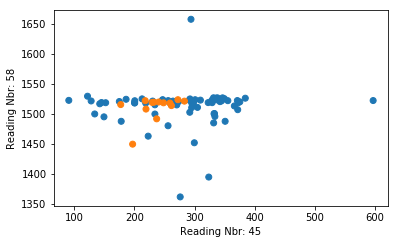

In [166]:
# credits: Andreas Mueller: Applied Machine Learning COMS 4995 Spring 2018
km = KMeans(n_clusters=2, random_state=0)
km.fit(turbine_readings.transpose())
print(km.cluster_centers_.shape)
print(km.labels_.shape)
# predict is the same as labels_ on training data
# but can be applied to new data
print(km.predict(turbine_readings.transpose()).shape)

import random
idx1 = random.randint(1,86)
idx2 = random.randint(1,86)
scatter_tab(turbine_readings.transpose()[idx1], turbine_readings.transpose()[idx2], c=km.labels_)
plt.gca().set_aspect("equal")
plt.xlabel('Reading Nbr: ' + str(idx1))
plt.ylabel('Reading Nbr: ' + str(idx2))
plt.show()

* Unsupervised evaluation of clustering to see the number of clusters
* Running the above clustering, we see that the turbines are not distinctive from the readings they generate.

In [167]:
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [168]:
rng = np.random.RandomState(1)
def cluster_stability(X, est, n_iter=20, random_state=None):
    labels = []
    indices = []
    for i in range(n_iter):
        # draw bootstrap samples, store indices
        sample_indices = rng.randint(0, X.shape[0], X.shape[0])
        indices.append(sample_indices)
        est = clone(est)
        if hasattr(est, "random_state"):
            # randomize estimator if possible
            est.random_state = rng.randint(1e5)
        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        # store clustering outcome using original indices
        relabel = -np.ones(X.shape[0], dtype=np.int)
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    scores = []
    for l, i in zip(labels, indices):
        for k, j in zip(labels, indices):
            # we also compute the diagonal which is a bit silly
            in_both = np.intersect1d(i, j)
            scores.append(adjusted_rand_score(l[in_both], k[in_both]))
    return np.mean(scores)

In [172]:
stability = []
silhouette = []
ari = []
cluster_range = range(2, 10, 1)
for n_clusters in cluster_range:
    km = KMeans(n_clusters=n_clusters)
    stability.append(cluster_stability(turbine_readings.transpose(), km))
    km.fit(turbine_readings.transpose())
    silhouette.append(silhouette_score(turbine_readings.transpose(), km.labels_))
    # ari.append(adjusted_rand_score(turbine_readings.transpose(), km.labels_))

Text(0.5,1,'Scanning n_clusters with different scores')

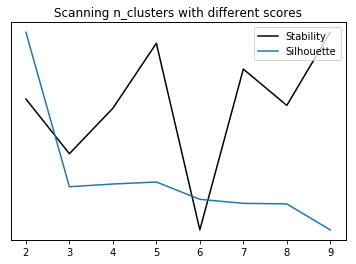

In [173]:
st, = plt.plot(cluster_range, stability, label="stability", c='k')
plt.yticks(())

si, = plt.twinx().plot(cluster_range, silhouette, label="silhouette")
plt.yticks(())

# ar, = plt.twinx().plot(cluster_range, ari, label="ari", c='r')
plt.yticks(())
plt.legend([st, si], ["Stability", "Silhouette"])
plt.xlabel("n_clusters")
plt.title("Scanning n_clusters with different scores")

* Because the number of clusters follow a decreasing trend, we assume that the turbines are the same without any signigicant difference.